### Load packages

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
np.set_printoptions(suppress=True)

### Loading datasets

In [43]:
# Read the directory paths from the text file
with open("Ldirectory.txt", "r") as file:
    lines = file.readlines()
    dailyprice_directory = lines[0].strip().split(":")[1].strip()
    sentiment_directory = lines[1].strip().split(":")[1].strip()

# Open dailyprice and sentiment files using the directory paths
price_data = pd.read_csv(dailyprice_directory)
sentiment_data = pd.read_excel(sentiment_directory, sheet_name=1)

Let's take a preliminary look at the datasets to gain an initial understanding of their contents and structure.

In [13]:
price_data.sample(7)

,date,1. open,2. high,3. low,4. close,5. volume,TickerName
279,2022-09-12,2.8100,2.9100,2.750,2.7800,100254,KSCP
13,2023-10-03,0.7405,0.7432,0.700,0.7200,668812,KSCP
501,2023-07-20,1.2400,1.2800,1.220,1.2700,32595,ASST
1142,2022-11-18,3.1300,3.2900,3.037,3.0400,230979,SNAL
310,2022-07-28,2.7100,2.9000,2.640,2.8700,180768,KSCP
1373,2022-11-29,0.7726,0.8498,0.770,0.8496,31558,MGAM
137,2023-04-05,0.7000,0.7027,0.630,0.6402,845029,KSCP


In [14]:
sentiment_data.sample(7)

,date,News Sentiment
12511,2014-04-22,0.068706
14917,2020-11-22,-0.130070
9453,2005-12-07,0.333954
3462,1989-07-13,0.112442
8967,2004-08-08,0.229089
13506,2017-01-11,0.300316
12053,2013-01-19,-0.141804


# Data Preparation

The data preparation phase that we are applying in this project as a part of CRISP-DM process involves several key steps. Initially, **data cleaning** is performed to address issues like missing values, outliers, and inconsistencies, ensuring the dataset is accurate and reliable. Next, **Feature engineering** tasks such as scaling and normalization to modify and restructure the data for better analysis. Finally, the dataset is split into training and testing **(train-test split)**, allowing for unbiased model evaluation and avoiding overfitting. These steps collectively ensure that the data is of high quality, suitable for analysis, and well-prepared for subsequent modeling and evaluation stages.

- Data Cleaning (pre-processing)
- Feature engineering
- Train/Test split

## Data Cleaning (Pre-processing)

- Formatting and type conversion
- Column concatination
- Column selection and dropping
- Missing value analysis
- Rename columns
- Outlier detection
- Duplicate detection


#### Formatting and type conversion

In [45]:
# changing date column to datetime
price_data['date']= pd.to_datetime(price_data['date'])

#### Column concatination

Before starting the data preparation process, let's merge the two datasets based on the 'date' column

In [46]:
joined_df = sentiment_data.set_index('date').join(price_data.set_index('date'), how='inner').reset_index()

#### Column selection and dropping

In this part we are identifying and selecting the columns that are relevant or necessary for our future analysis and modeling.

In [47]:
#Drop specific columns
columns_to_drop = ['2. high', '3. low', '1. open']
joined_df = joined_df.drop(columns=columns_to_drop)

# Print the modified DataFrame
joined_df

,date,News Sentiment,4. close,5. volume,TickerName
0,2022-01-27,-0.048525,5.9100,1608576,KSCP
1,2022-01-28,-0.058983,16.2900,26574308,KSCP
2,2022-01-31,-0.067368,21.4000,42899912,KSCP
3,2022-02-01,-0.070566,12.4400,18493106,KSCP
4,2022-02-02,-0.061209,9.5500,12613046,KSCP
...,...,...,...,...,...
1429,2023-10-13,-0.073652,0.8716,598178,KSCP
1430,2023-10-13,-0.073652,0.5361,502908,ASST
1431,2023-10-13,-0.073652,8.6900,476329,GCT
1432,2023-10-13,-0.073652,1.4000,4298,SNAL


#### Missing value analysis

In [48]:
has_nulls = joined_df.isnull().any().any()

# Check if the dataset has null values
if has_nulls:
    print("The dataset contains null values.")
else:
    print("The dataset does not have any null values.")

The dataset does not have any null values.


Based on the absence of null values in the dataset, the data has been thoroughly examined and found to be free of any missing values. Consequently, we can confidently proceed to the subsequent steps.

#### Rename columns

We are renaming our columns to better reflect the content of our dataset

In [49]:
old_names = ['date', 'News Sentiment', '4. close', '5. volume', 'TickerName']
new_names = ['date', 'News Sentiment', 'close', 'volume']

# Create a mapping dictionary from old names to new names
column_mapping = dict(zip(old_names, new_names))

# Rename the columns using the mapping dictionary
joined_df = joined_df.rename(columns=column_mapping)
joined_df.sample(7)

,date,News Sentiment,close,volume,TickerName
950,2023-05-26,-0.390812,0.9649,166342,ASST
123,2022-07-26,-0.214017,2.6700,131266,KSCP
310,2022-11-01,-0.186335,3.3800,138574,KSCP
1047,2023-06-26,-0.206809,1.6200,19910,SNAL
1007,2023-06-13,-0.305765,1.5900,11470,SNAL
1200,2023-08-09,-0.066726,1.1200,46996,ASST
305,2022-10-28,-0.248491,4.8600,73360,GCT


#### Outlier detection

In [50]:
# Select the numerical columns for outlier detection
numeric_cols = ['News Sentiment', 'close', 'volume']

# Compute the Z-scores for each numeric column
z_scores = np.abs((joined_df[numeric_cols] - joined_df[numeric_cols].mean()) / joined_df[numeric_cols].std())

# Set the threshold for outlier detection (e.g., Z-score threshold of 3)
z_score_threshold = 3

# Identify outliers by checking if the Z-score exceeds the threshold
outliers = joined_df[z_scores > z_score_threshold]

# Print the outliers
print(outliers)

     date  News Sentiment  close      volume TickerName
0     NaT             NaN    NaN         NaN        NaN
1     NaT             NaN  16.29  26574308.0        NaN
2     NaT             NaN  21.40  42899912.0        NaN
3     NaT             NaN    NaN  18493106.0        NaN
4     NaT             NaN    NaN         NaN        NaN
...   ...             ...    ...         ...        ...
1429  NaT             NaN    NaN         NaN        NaN
1430  NaT             NaN    NaN         NaN        NaN
1431  NaT             NaN    NaN         NaN        NaN
1432  NaT             NaN    NaN         NaN        NaN
1433  NaT             NaN    NaN         NaN        NaN

[1434 rows x 5 columns]


Given the complexity of the previous output, visualizing the outliers through plotting is a more comprehensible approach. The following code facilitates a clearer understanding of the data by creating a boxplot that highlights outliers.

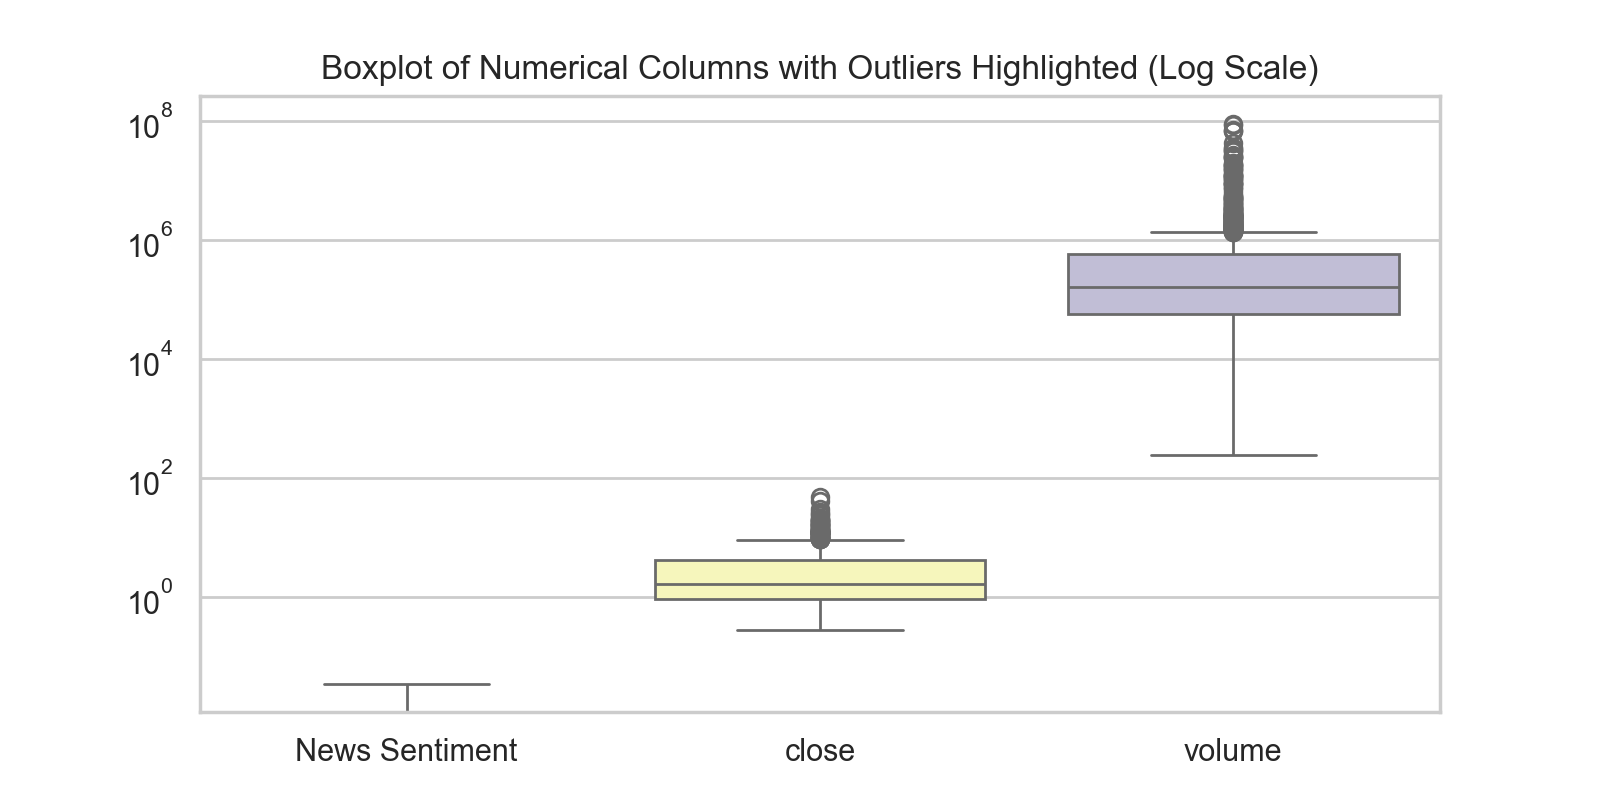

C:\Users\babyl\AppData\Local\Temp\ipykernel_40068\917716136.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



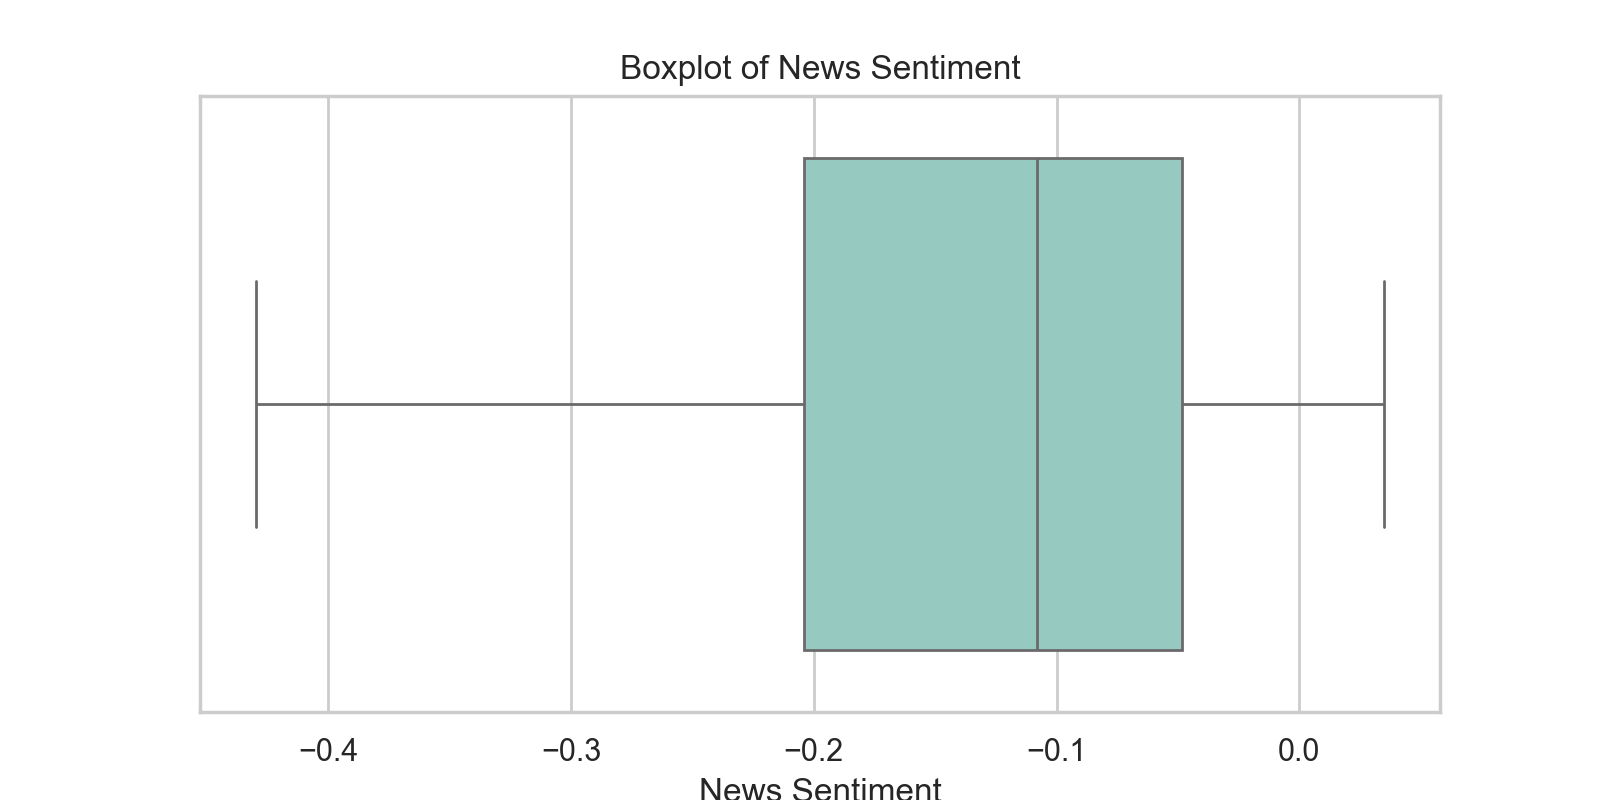

In [65]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Create a boxplot for each numerical column with log scale on the y-axis
plt.figure(figsize=(8, 4))
sns.boxplot(data=joined_df.drop(columns=['date', 'TickerName']), palette="Set3")
plt.yscale("log")  # Apply logarithmic scale to the y-axis
plt.title("Boxplot of Numerical Columns with Outliers Highlighted (Log Scale)")
plt.show()

# Separate boxplot for 'News Sentiment'
plt.figure(figsize=(8, 4))
sns.boxplot(x=joined_df['News Sentiment'], palette="Set3")
plt.title("Boxplot of News Sentiment")
plt.show()


**Plot interpretation:**
In all of the plots, log scales were used to make the small values more visible. In the first plot, both the close and volume columns have numerous outliers, indicating that some values are extreme. This suggests that the range of 75 percent of the data has a narrower span.

#### Duplicate detection

In [60]:
# Detect duplicates based on all columns
duplicates = joined_df[joined_df.duplicated()]


# Check if duplicates are found
if duplicates.empty:
    print("No duplicates found in the dataset.")
else:
    print("Duplicates in the dataset:")
    print(duplicates)


No duplicates found in the dataset.


Based on the previous output, we can observe that our dataset does not contain any duplicate records. Therefore, we can confidently proceed to the next step of our analysis.

## Feature Engineering

In this section, we will perform tasks such as transforming the values of features that we believe will help improve the performance of the model we are going to use. Our main goal here is to extract relevant information from the data, refine the feature representation, and present it in a way that makes it easier for our models to learn and make accurate predictions. Overall, our aim is to enhance the model's performance by optimizing the features and their representation.

- Mathematical transformation
- scaling numerical features

#### Mathmatical transformation

Here, we are primarily focusing on the 'close price' column, which serves as our dependent variable. Initially, the data is represented in terms of prices. However, for our model and business problem, we require the percentage change on a daily basis. This is where the transformation process becomes useful

In [78]:
joined_df['close'] = joined_df['close'].pct_change()*100
# Fill NaN values in the 'PercentageChange' column with a default value (e.g., 0)

In [79]:
joined_df.dropna(subset = ['close'], inplace = True)
joined_df.sample(5)

,date,News Sentiment,close,volume,TickerName
903,2023-05-12,-0.366826,-63.183112,121859,MGAM
964,2023-06-01,-0.406532,-21.296296,2377614,KSCP
895,2023-05-11,-0.347136,91.420455,150909,ASST
564,2023-02-06,-0.088435,-46.000000,272694,KSCP
1157,2023-07-27,-0.044954,-77.804584,24062,SNAL


#### Scaling numerical features

In [80]:
# Extract numerical columns
numerical_cols = joined_df.select_dtypes(include=[np.number]).columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply standard scaling to the numerical columns
joined_df_scaled = joined_df.copy()
joined_df_scaled[numerical_cols] = scaler.fit_transform(joined_df[numerical_cols])


In [81]:
joined_df_scaled.sample(7)

,date,News Sentiment,close,volume,TickerName
841,2023-04-26,-0.598917,1.000635,-0.208683,GCT
711,2023-03-20,-0.611771,0.196370,-0.202950,GCT
917,2023-05-17,-1.942578,-0.509172,-0.220011,SNAL
226,2022-09-22,0.074624,-0.242055,-0.193535,KSCP
1192,2023-08-07,0.800033,-0.536072,-0.216792,SNAL
1083,2023-07-06,0.545798,-0.495641,-0.201127,MGAM
453,2022-12-23,-0.050995,-0.519317,-0.214114,SNAL


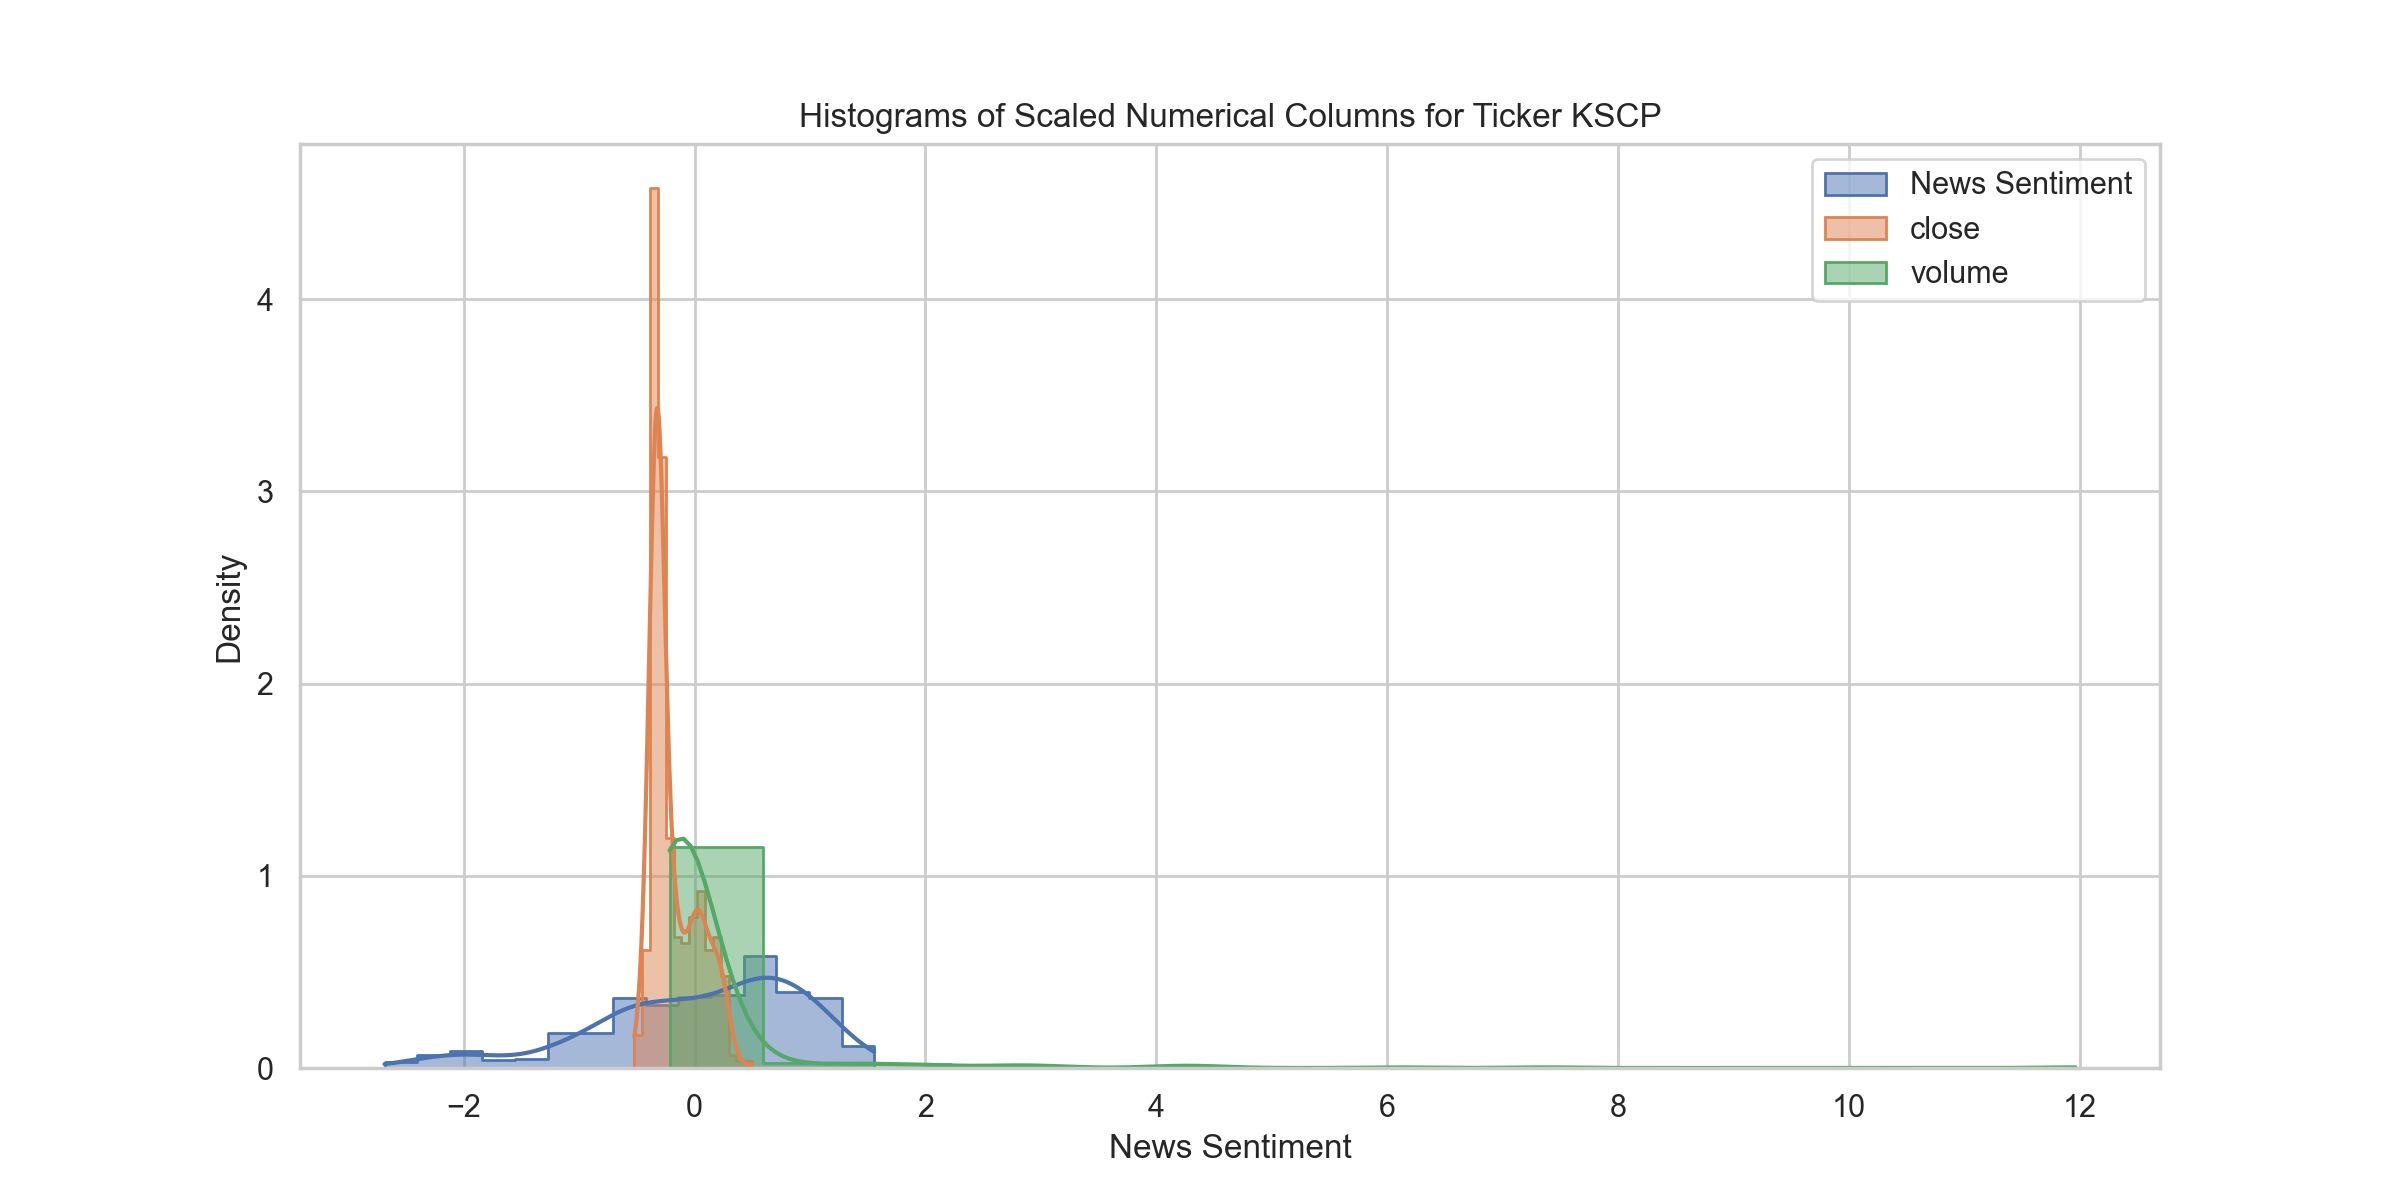

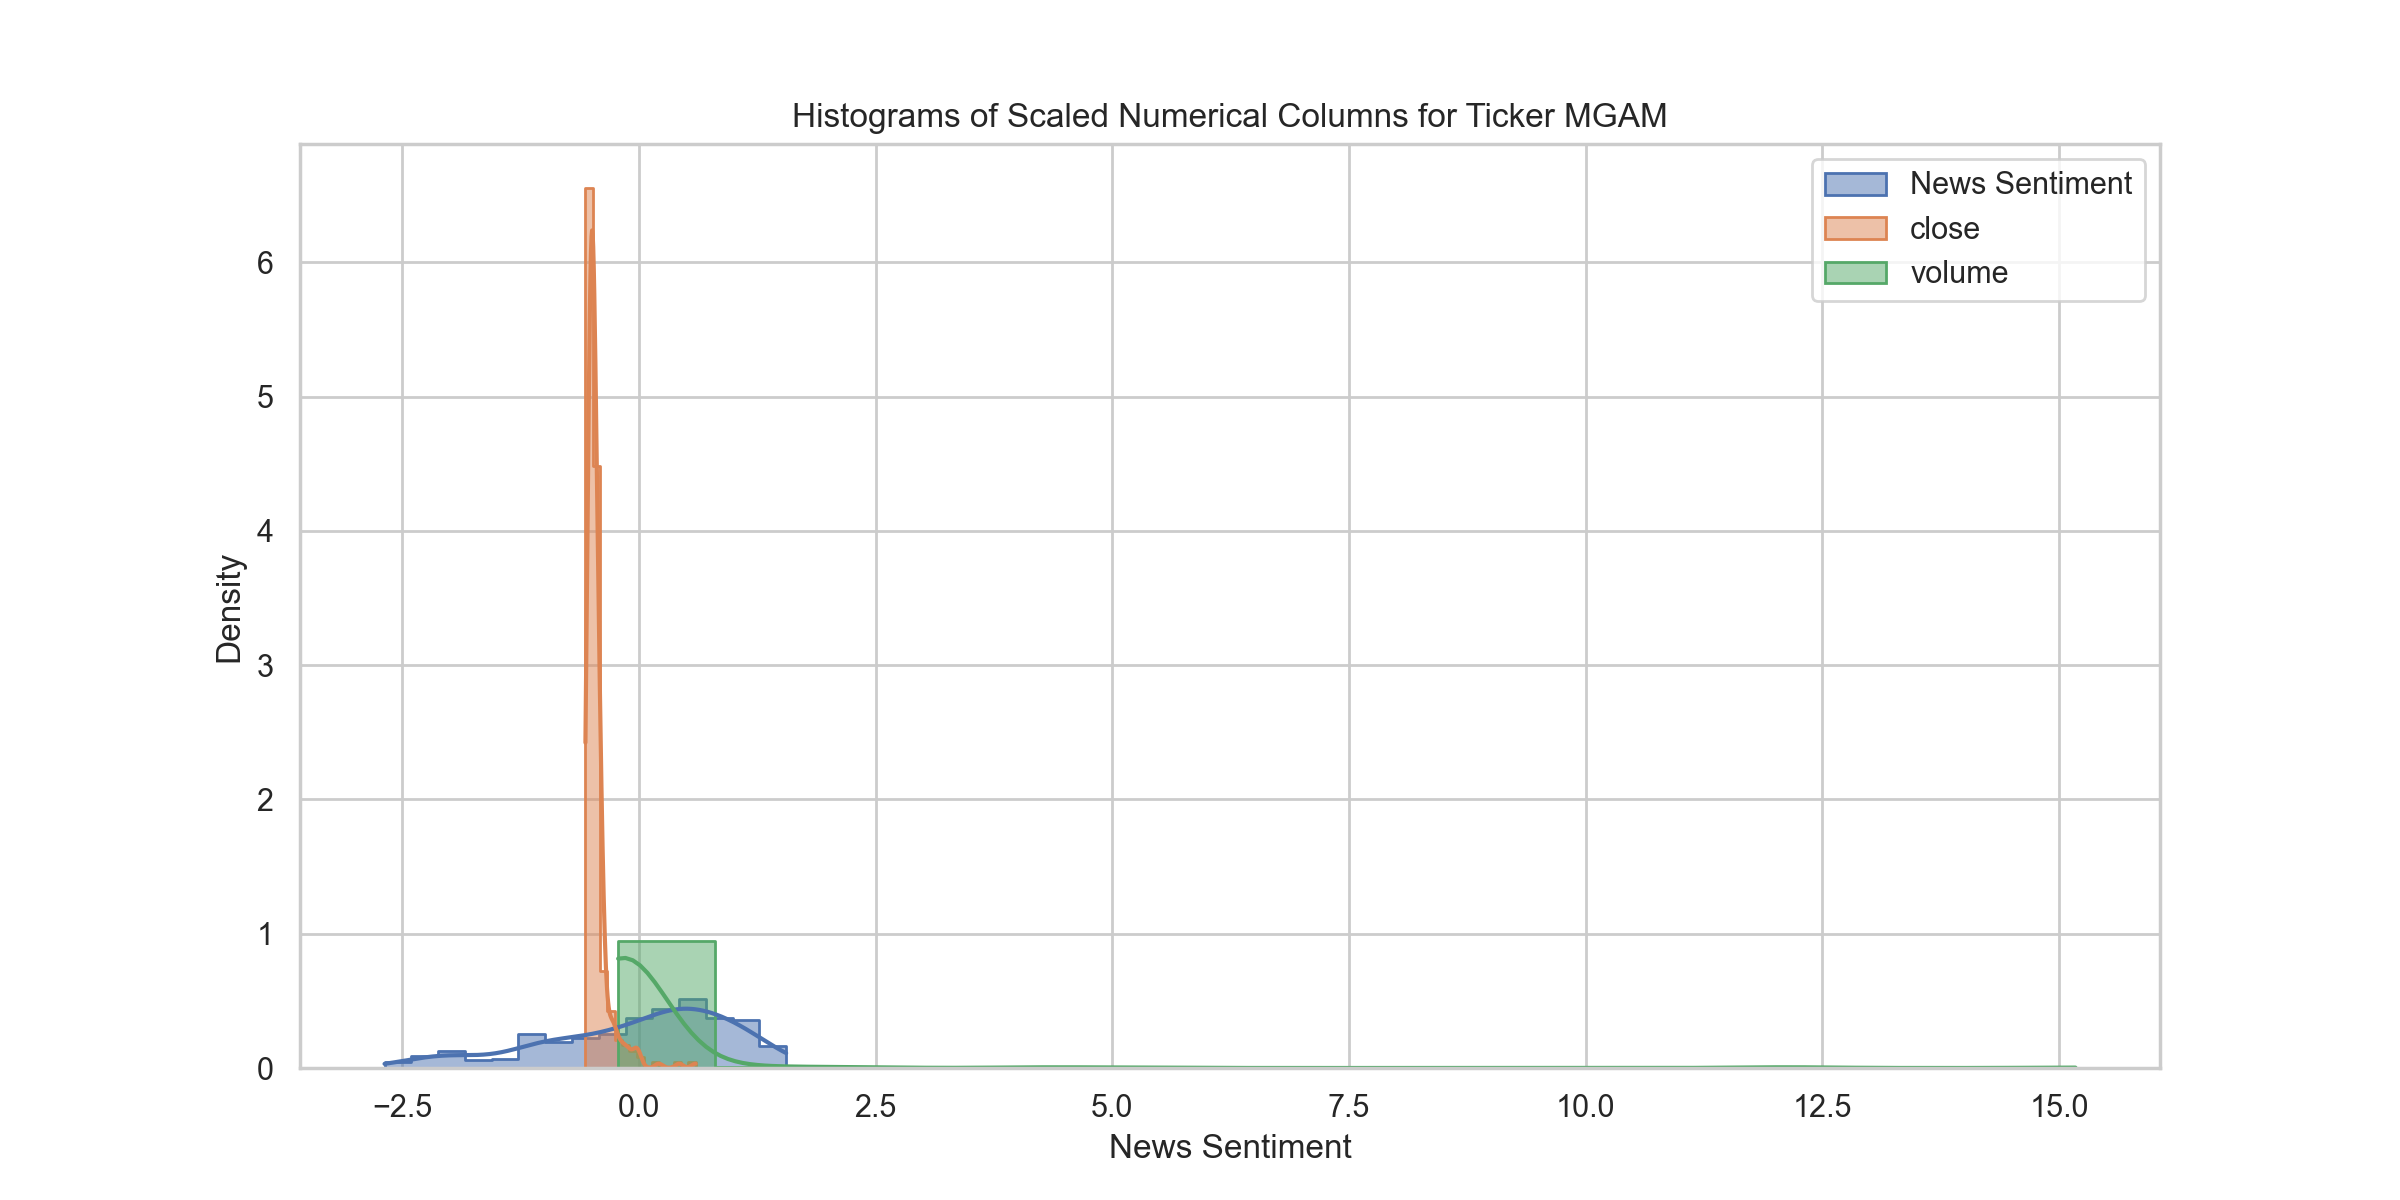

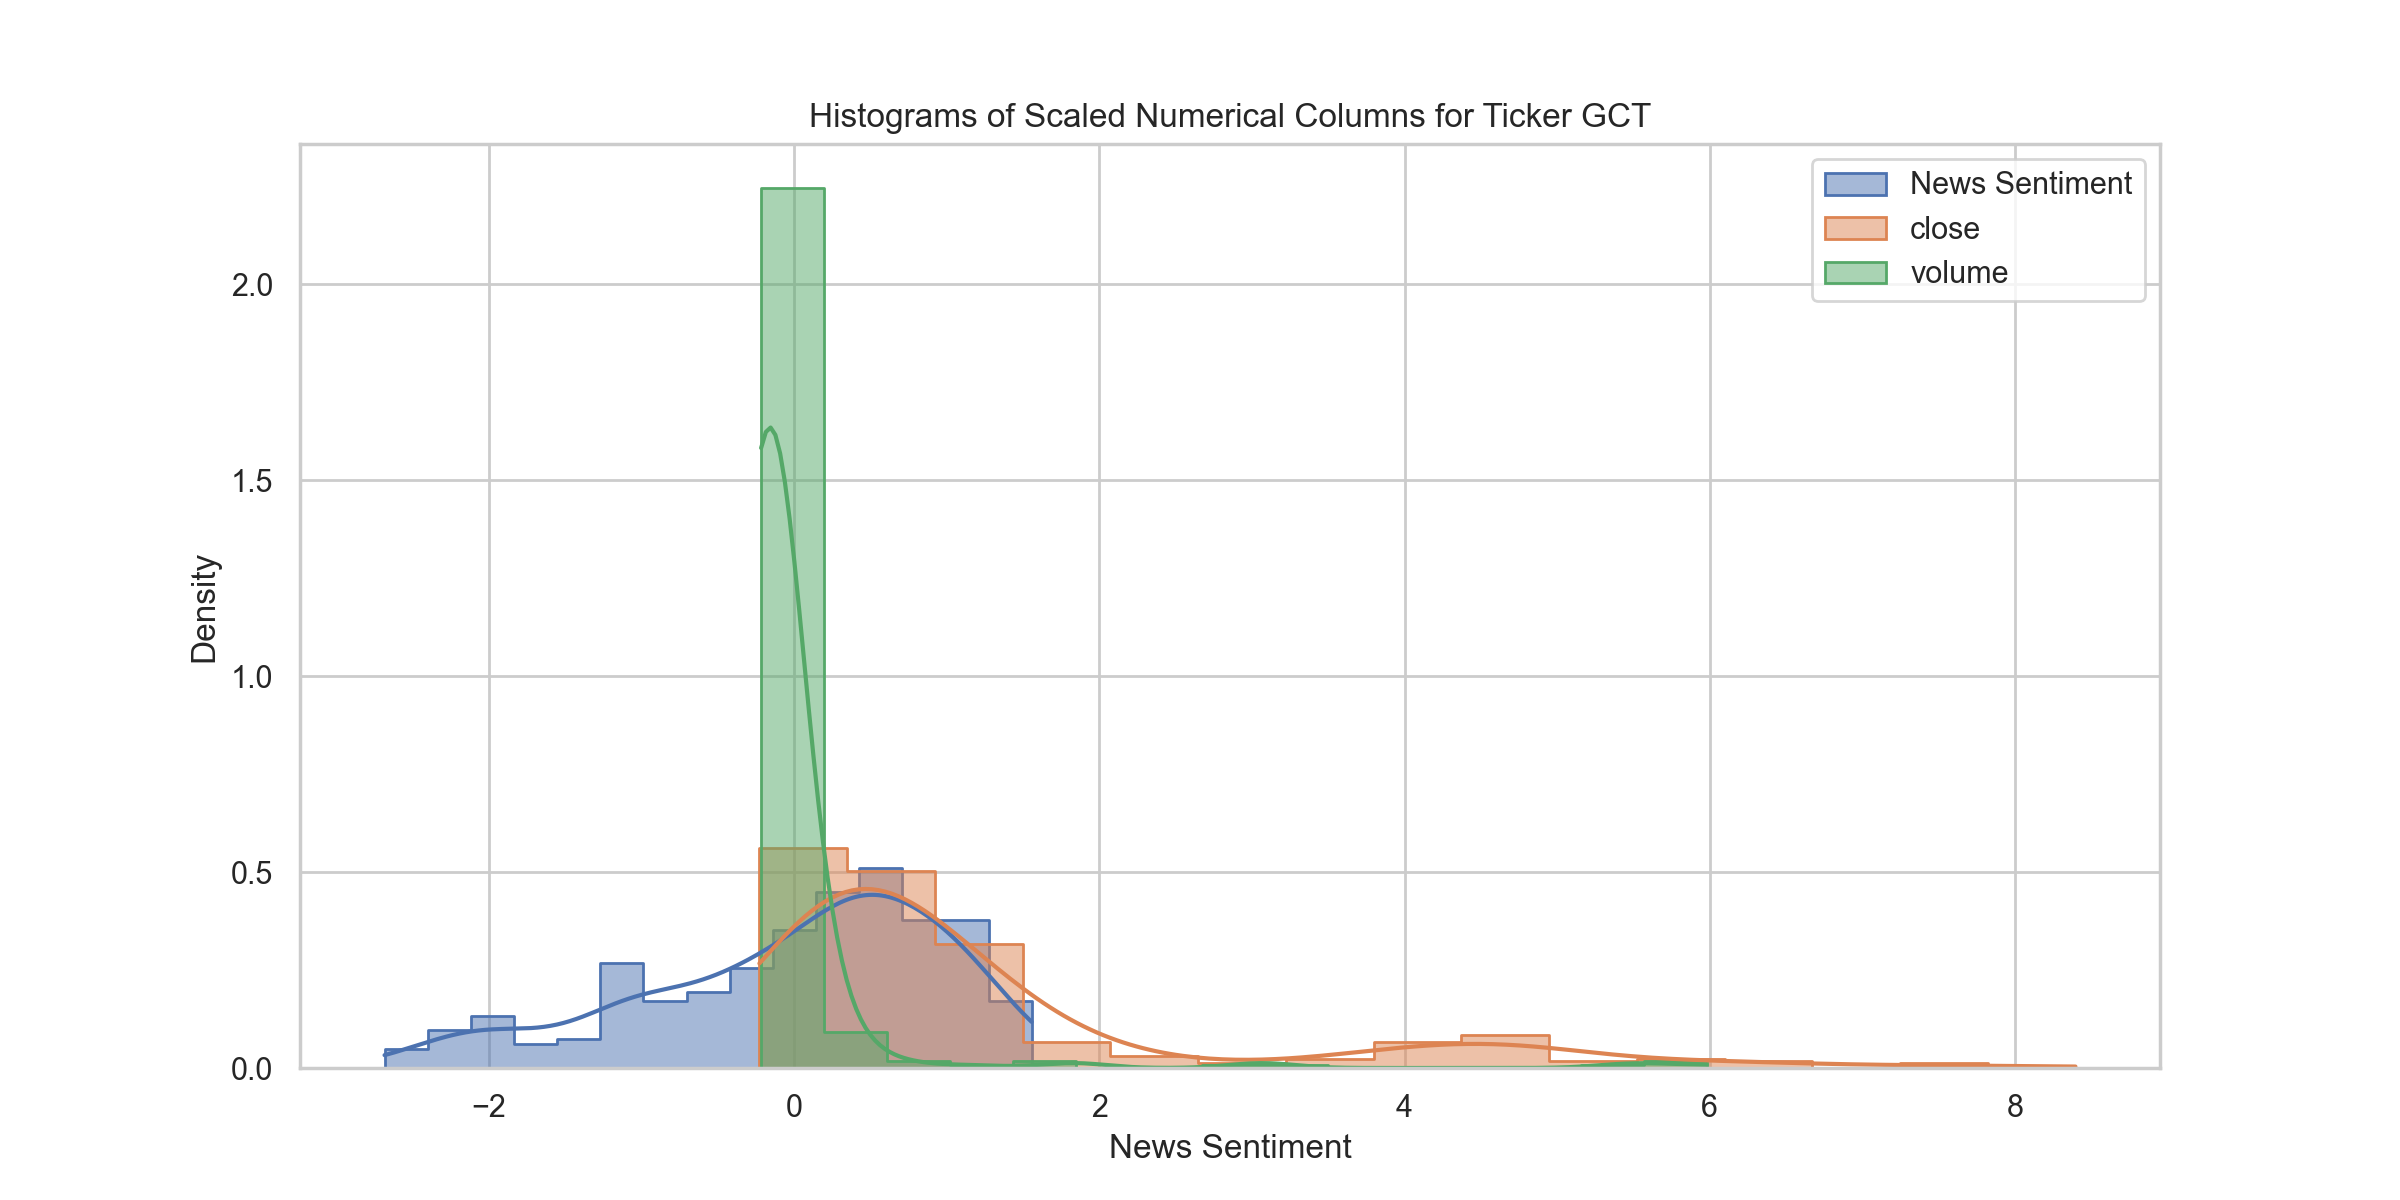

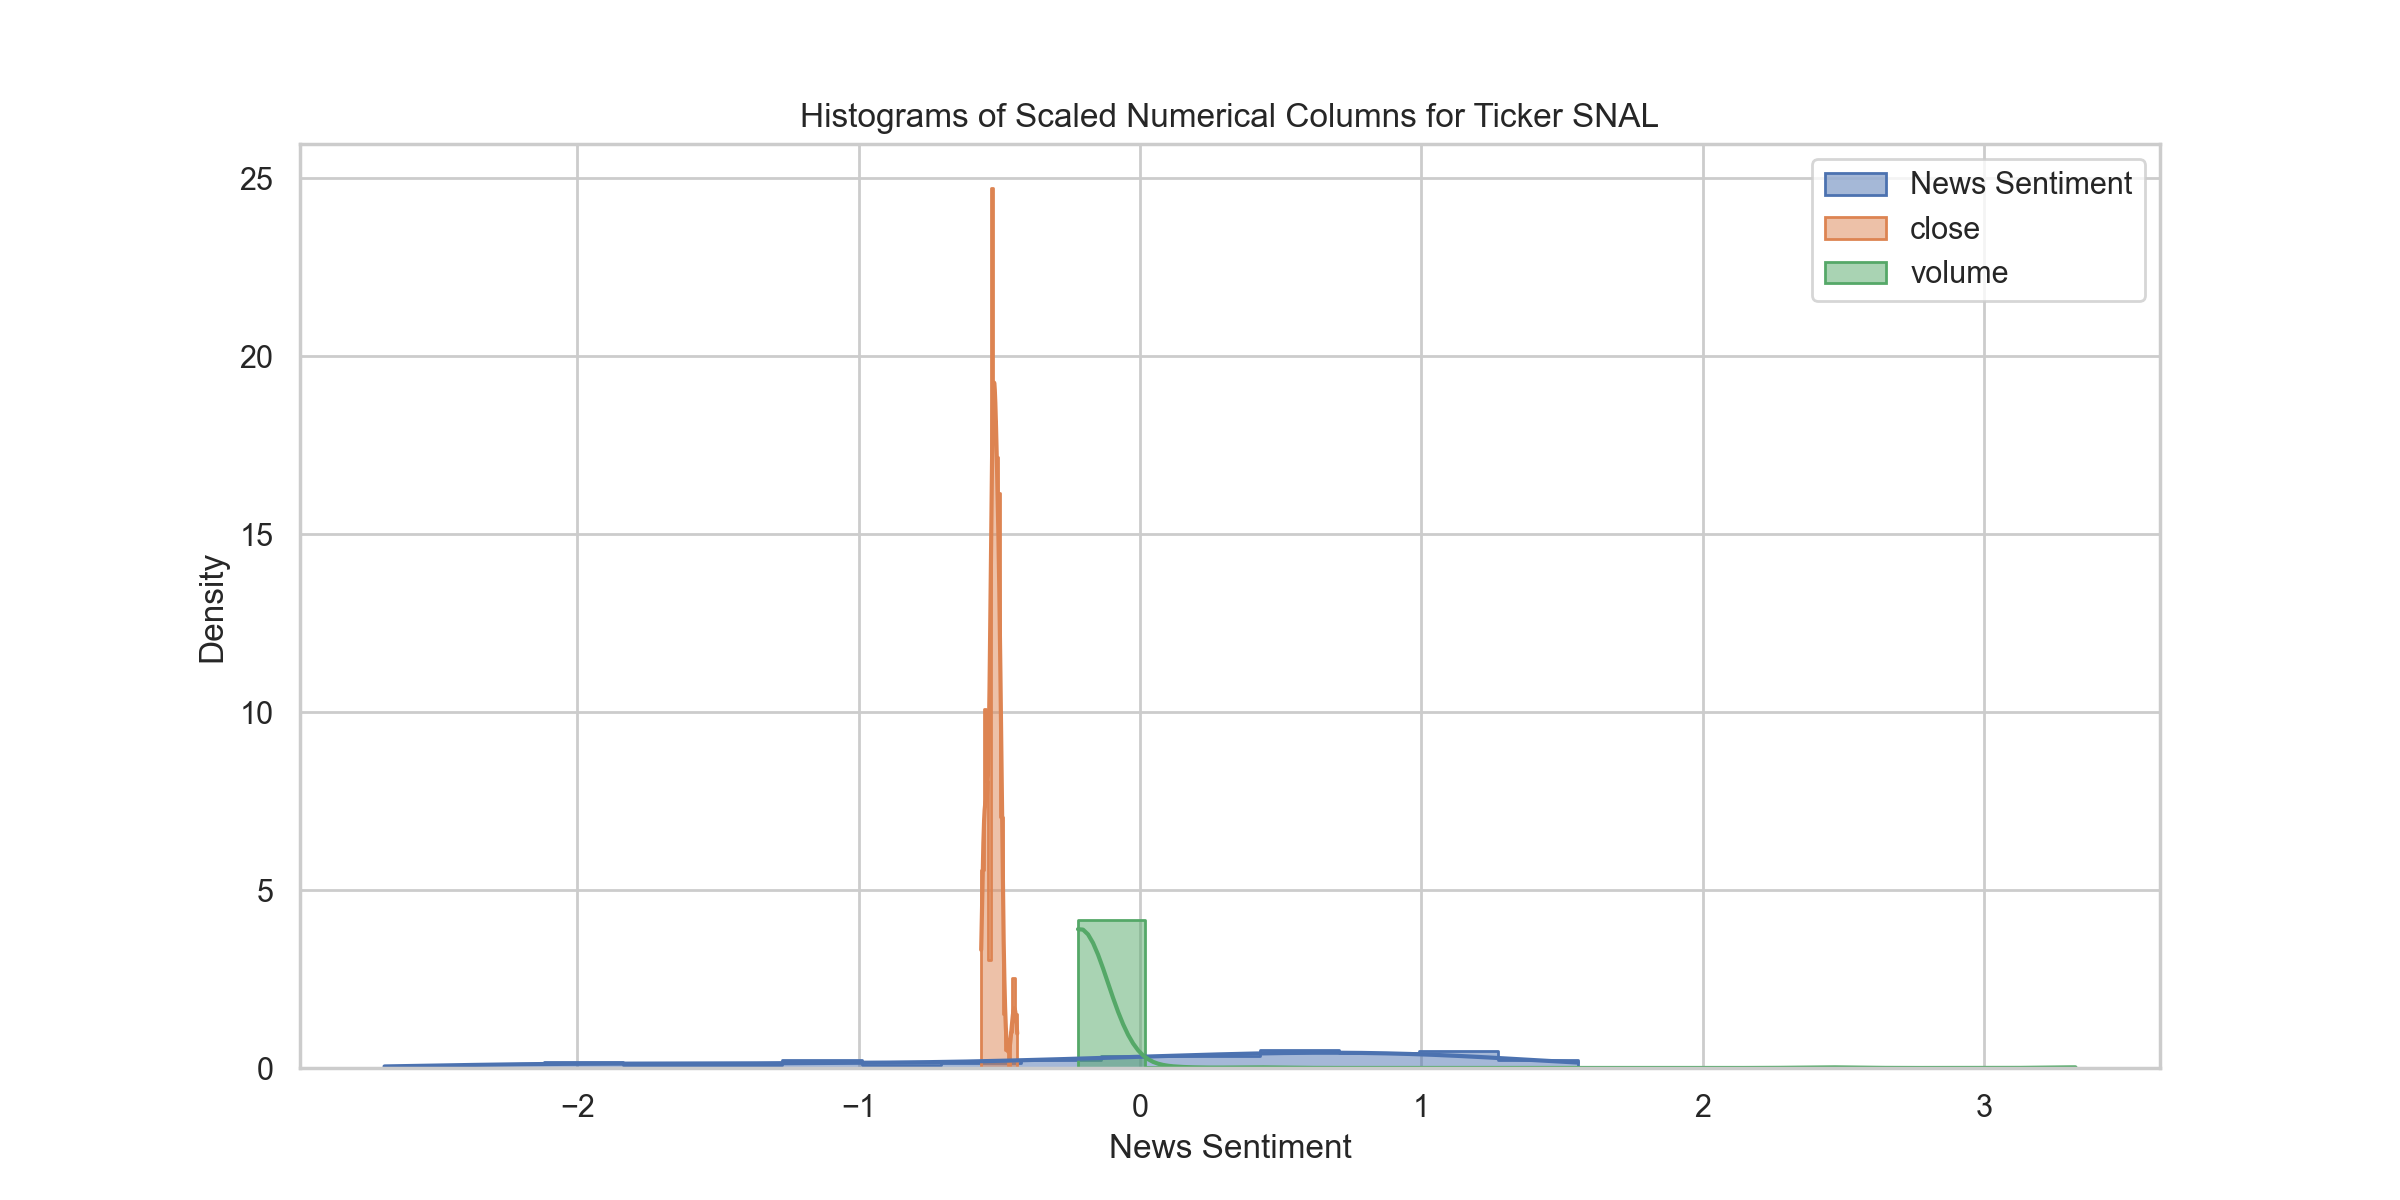

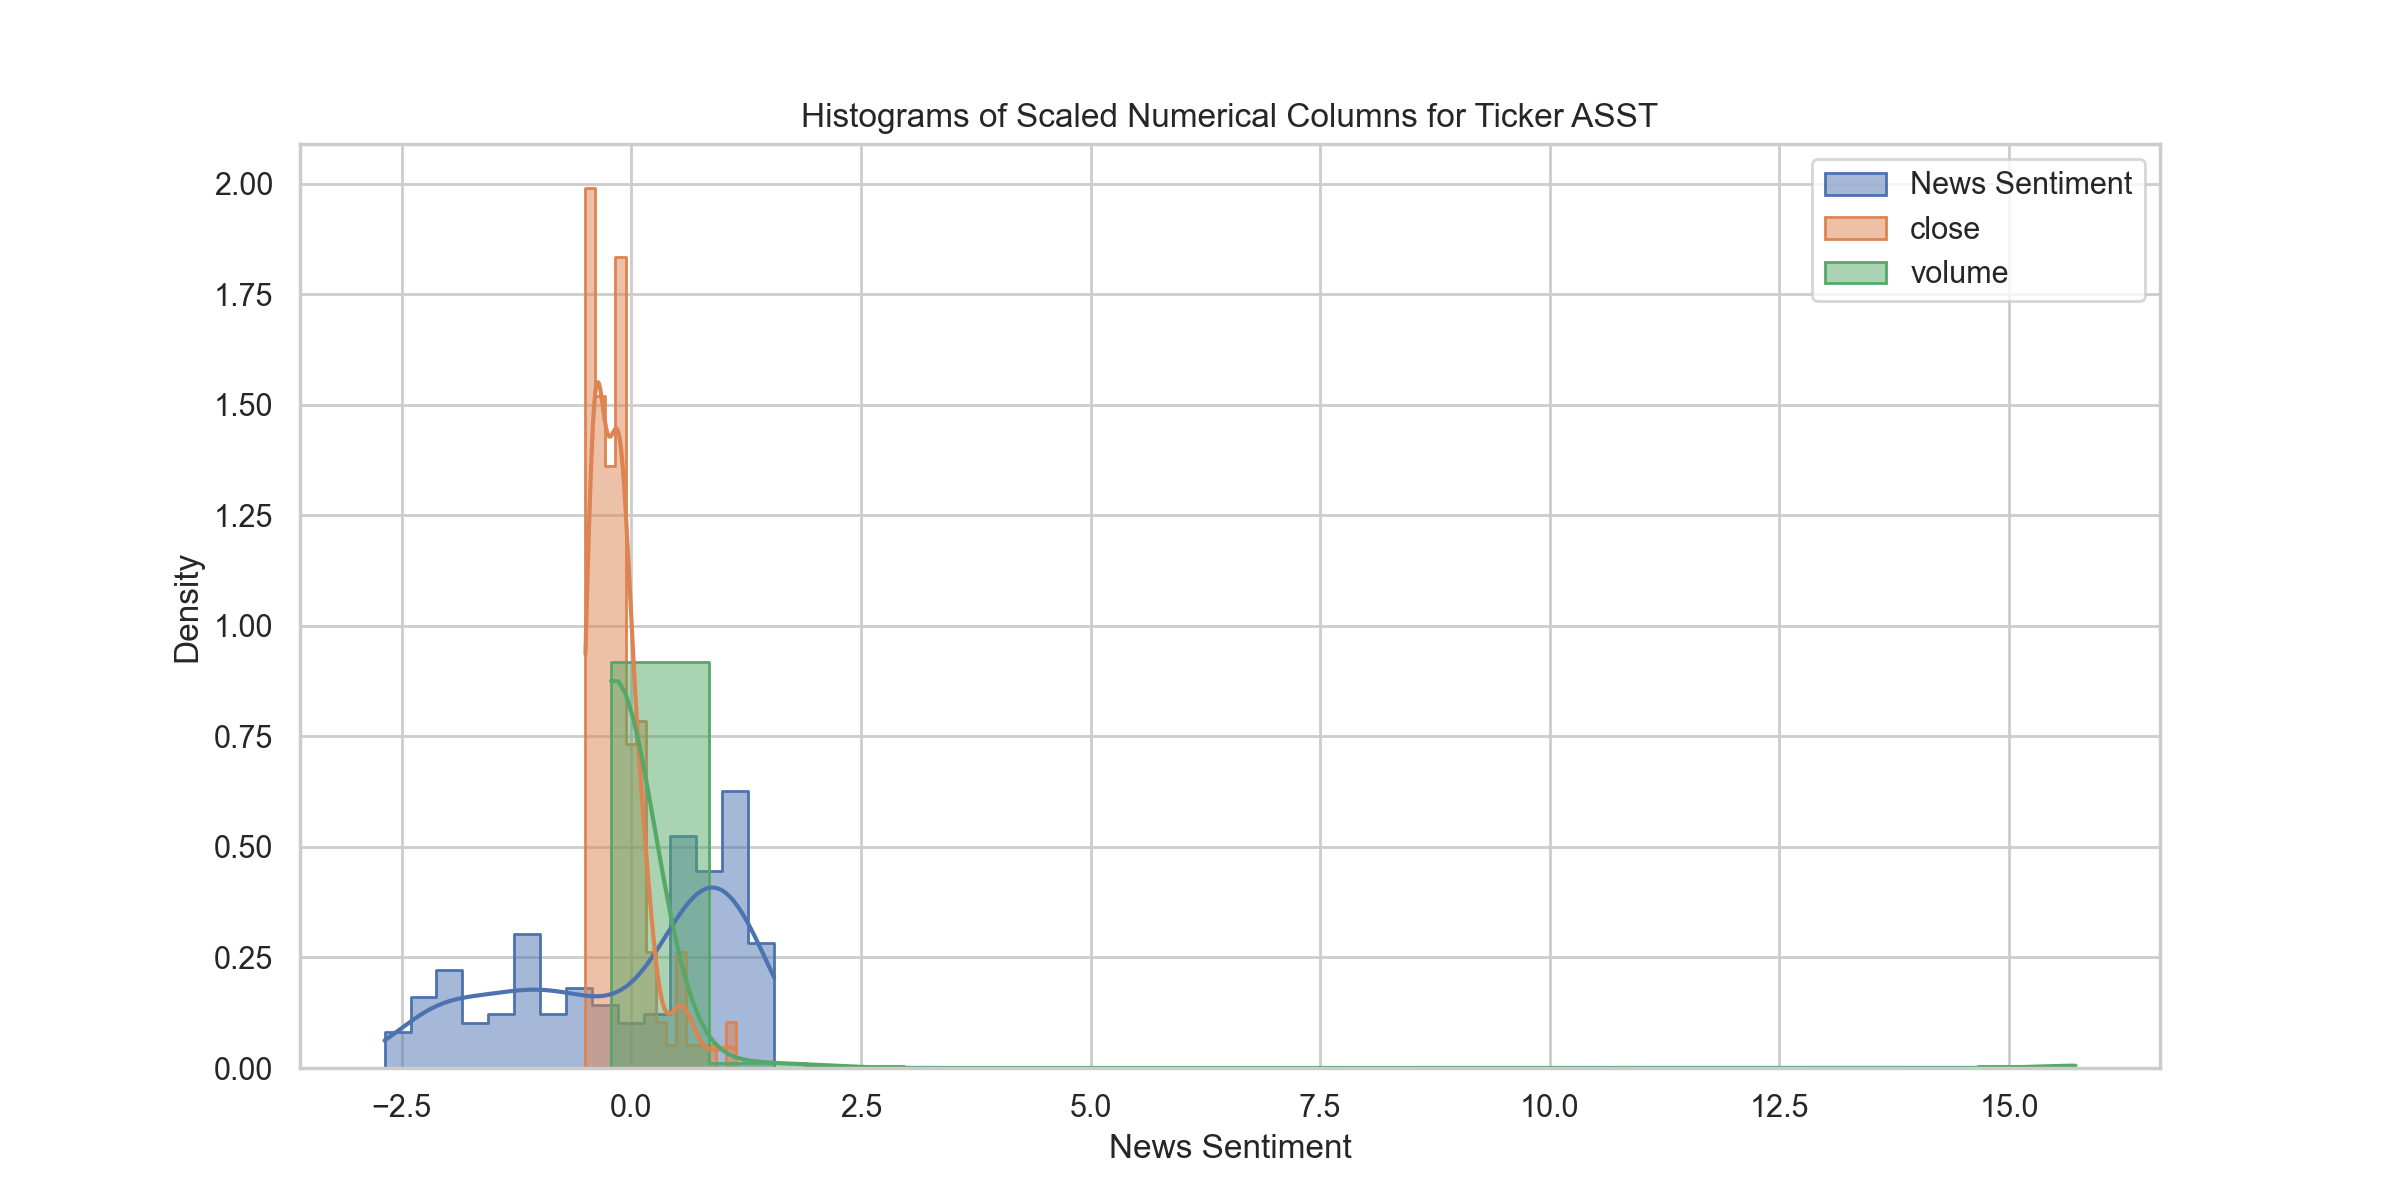

In [85]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Iterate over each unique ticker
for ticker in joined_df_scaled['TickerName'].unique():
    # Filter the scaled data based on the current ticker
    filtered_data = joined_df_scaled[joined_df_scaled['TickerName'] == ticker]

    # Plot histograms for each numerical column, grouped by 'TickerName'
    plt.figure(figsize=(12, 6))
    for col in numerical_cols:
        sns.histplot(data=filtered_data, x=col, kde=True, label=col, element="step", stat="density", common_norm=False, bins=15)  # Adjust the bins parameter

    plt.title(f"Histograms of Scaled Numerical Columns for Ticker {ticker}")
    plt.legend()
    plt.show()



## Train-Test split

In [ ]:
from sklearn.model_selection import train_test_split

train = pd.DataFrame()
test = pd.DataFrame()

for ticker in fixed_data["TickerName"].unique():

    current_ticker_data = fixed_data[fixed_data["TickerName"] == ticker]
    
    train_sub, test_sub = train_test_split(current_ticker_data, test_size=0.3, shuffle=False)
    
    train = pd.concat([train, train_sub], ignore_index=True)
    test = pd.concat([test, test_sub], ignore_index=True)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

numerical_cols = train.select_dtypes(include=[np.number]).columns

scaler.fit(train[numerical_cols])

train_scaled = train
test_scaled = test
train_scaled[numerical_cols] = scaler.transform(train[numerical_cols])
test_scaled[numerical_cols] = scaler.transform(test[numerical_cols])

In [ ]:
print(f"Train set shape: {train_scaled.shape}")
print(f"Test set shape: {test_scaled.shape}")
print(f"Our latest training date is {train_scaled['date'].max()}")

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(24, 12))
colors = ["b", "g", "r", "c", "m"]


unique_tickers = train_scaled["TickerName"].unique()

for index, i in enumerate(unique_tickers):
    row_index, col_index = divmod(index, 3)
    

    ax = axes[row_index, col_index]
    
    temporary = train_scaled[train_scaled["TickerName"] == i]

    ax.plot(temporary["date"], temporary["close"], label=i, color=colors[index])
    ax.set_xticks(temporary["date"].unique()[0:len(temporary["date"].unique()):30])
    ax.set_ylabel("Price Change (%)")
    ax.tick_params(axis='x', rotation=45)  
    ax.set_title(i) 


fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()